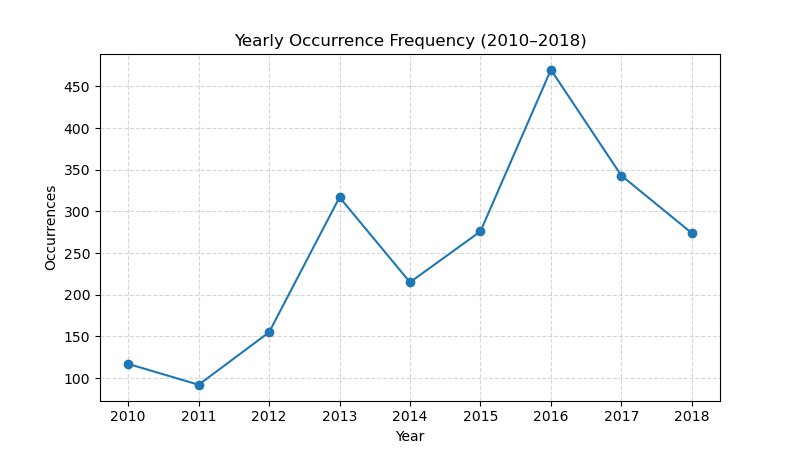

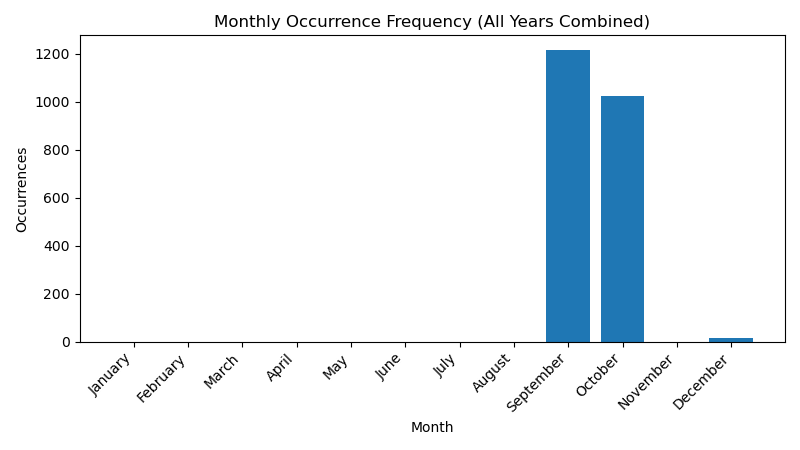

In [15]:
# filename: make_halodule_frequencies.py
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from pathlib import Path

# ========= Configuration =========
INPUT_XLSX = "Townsville_Halodule_uninervis_2010-2018.xlsx"  # file NAME
MAKE_PLOTS = True
OUTPUT_PREFIX = "halodule"
# ======================

def normalize_month(val):
    if pd.isna(val): return np.nan
    s = str(val).strip()
    if s.isdigit():
        m = int(float(s))
        return m if 1 <= m <= 12 else np.nan
    s_title = s.capitalize()
    month_map = {m: i for i, m in enumerate(
        ["January","February","March","April","May","June","July","August",
         "September","October","November","December"], start=1)}
    if s_title in month_map: return month_map[s_title]
    abbr_map = {name[:3]: idx for name, idx in month_map.items()}
    return abbr_map.get(s_title[:3], np.nan)

def presence_mask(df):
    n = len(df)
    mask = pd.Series(True, index=df.index)
    def to_bool(col):
        return df[col].astype(str).str.strip().str.lower().isin(
            {"yes", "present", "1", "true"}
        )
    if "H_UNINERVI" in df.columns: mask &= to_bool("H_UNINERVI")
    if "PRESENCE_A" in df.columns: mask &= to_bool("PRESENCE_A")
    return mask

def pick_excel_engine():
    """FIRST openpyxl；IFNOT THEN RETURN None（SKIP TO WRITE xlsx）。"""
    try:
        import openpyxl  # noqa: F401
        return "openpyxl"
    except Exception:
        return None

def main():
    # Compatible scripts/Notebook path processing
    try:
        here = Path(__file__).resolve().parent
    except NameError:
        here = Path.cwd()

    in_path = here / INPUT_XLSX
    if not in_path.exists():
        raise FileNotFoundError(f"CANT FINE FILE：{in_path}")

    df = pd.read_excel(in_path)

    # CHECK
    if "YEAR" not in df.columns:
        raise ValueError("缺少 'YEAR' 列")
    if "MONTH" not in df.columns:
        raise ValueError("缺少 'MONTH' 列")

    # FILTER“EXIST”
    data = df.loc[presence_mask(df)].copy()
    data["Year"] = pd.to_numeric(data["YEAR"], errors="coerce")
    data["Month"] = data["MONTH"].apply(normalize_month)

    # YEAR RATE
    yearly = (data.dropna(subset=["Year"])
              .groupby("Year").size()
              .reset_index(name="Occurrences")
              .sort_values("Year"))

    # Monthly frequency (across all years)
    monthly = (data.dropna(subset=["Month"])
               .groupby("Month").size()
               .reindex(range(1, 13), fill_value=0)
               .reset_index(name="Occurrences"))
    monthly["Month_Name"] = monthly["Month"].apply(
        lambda m: pd.Timestamp(2000, int(m), 1).strftime("%B")
    )

    # month by month sequence YYYY-MM
    month_series = data.dropna(subset=["Year", "Month"]).copy()
    month_series["Month_Period"] = month_series.apply(
        lambda r: f"{int(r['Year']):04d}-{int(r['Month']):02d}", axis=1
    )
    month_series = (month_series.groupby("Month_Period")
                    .size().reset_index(name="Occurrences")
                    .sort_values("Month_Period"))

    # OUTPUT
    out_year_csv = here / f"{OUTPUT_PREFIX}_year_frequency_2010-2018.csv"
    out_month_csv = here / f"{OUTPUT_PREFIX}_month_frequency_all_years.csv"
    out_series_csv = here / f"{OUTPUT_PREFIX}_month_year_frequency_2010-2018.csv"
    out_excel = here / f"{OUTPUT_PREFIX}_frequencies_2010-2018.xlsx"

    # WRITE CSV
    yearly.to_csv(out_year_csv, index=False)
    monthly.to_csv(out_month_csv, index=False)
    month_series.to_csv(out_series_csv, index=False)

    # WRITE Excel（FIRST openpyxl；NOT TO SKIP）
    engine = pick_excel_engine()
    if engine:
        with pd.ExcelWriter(out_excel, engine=engine) as writer:
            yearly.to_excel(writer, sheet_name="Yearly", index=False)
            monthly.to_excel(writer, sheet_name="MonthlyCalendar", index=False)
            month_series.to_excel(writer, sheet_name="MonthlySeries", index=False)
        print("✅ Excel WRITE DONE：", out_excel.name)
    else:
        print("⚠️ NO INSTALL openpyxl，SKIP xlsx OUTPUT，GENERATE CSV。"
              " IF NEED xlsx：pip install openpyxl")

    print("✅ YEAR RATE CSV：", out_year_csv.name)
    print("✅ MONTH RATE CSV：", out_month_csv.name)
    print("✅ month by month sequence CSV：", out_series_csv.name)
    print(f"Records filtered as exist：{len(data)} / TOTAL LINES：{len(df)}")
    # DRAW PICTURE（matplotlib，No style/color specified）
    if MAKE_PLOTS:
        import matplotlib.pyplot as plt

        # annual trend
        fig1 = plt.figure(figsize=(8, 4.5))
        plt.plot(yearly["Year"], yearly["Occurrences"], marker="o")
        plt.title("Yearly Occurrence Frequency (2010–2018)")
        plt.xlabel("Year"); plt.ylabel("Occurrences")
        plt.grid(True, linestyle="--", alpha=0.5)
        fig1.savefig(here / f"{OUTPUT_PREFIX}_yearly_trend.png"); plt.close(fig1)

        # Monthly distribution
        fig2 = plt.figure(figsize=(8, 4.5))
        x = monthly["Month"]
        plt.bar(x, monthly["Occurrences"])
        plt.xticks(x, monthly["Month_Name"], rotation=45, ha="right")
        plt.title("Monthly Occurrence Frequency (All Years Combined)")
        plt.xlabel("Month"); plt.ylabel("Occurrences")
        plt.tight_layout()
        fig2.savefig(here / f"{OUTPUT_PREFIX}_monthly_distribution.png"); plt.close(fig2)

        print("🖼️ Picture saved：",
              f"{OUTPUT_PREFIX}_yearly_trend.png, {OUTPUT_PREFIX}_monthly_distribution.png")
from IPython.display import display, Image
display(Image(filename="halodule_yearly_trend.png"))
display(Image(filename="halodule_monthly_distribution.png"))


✅ USING DATA FILE： /home/5013f3a6-a71a-4379-a32a-ece10ae96935/gladstone.csv
📘 WRITTEN： gladstone_combined_frequencies.xlsx
✅ Done. OUTPUT：
 - gladstone_year_frequency.csv
 - gladstone_month_frequency.csv
 - gladstone_month_year_series.csv
 - gladstone_yearly_trend.png
 - gladstone_monthly_distribution.png


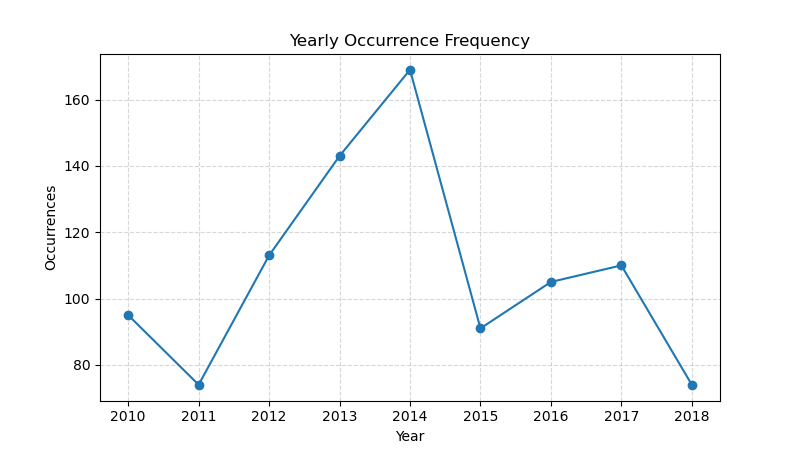

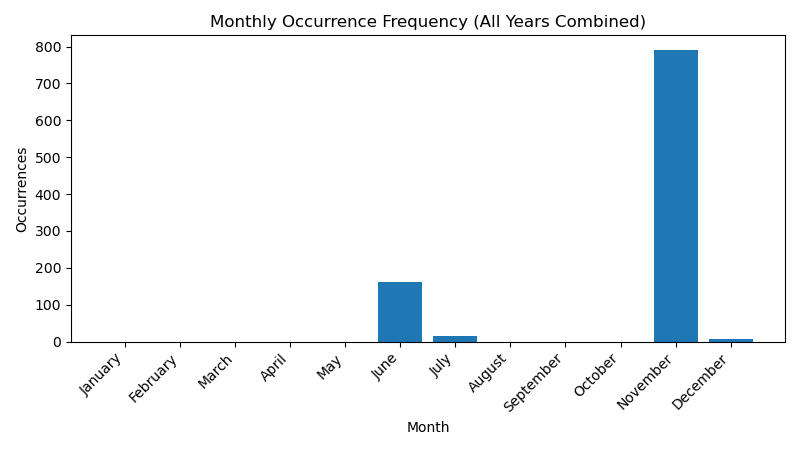

In [18]:
# === One-Cell Final: combine frequencies + plots for gladstone.csv ===
import re, sys
import pandas as pd
import numpy as np
from pathlib import Path

# ---- 1) Find files (current directory/parent directory + fuzzy match)----
TARGET_NAME = "gladstone.csv"

try:
    HERE = Path(__file__).resolve().parent
except NameError:
    HERE = Path.cwd()

cands = [
    HERE / TARGET_NAME,
    HERE / TARGET_NAME.strip(),
    HERE.parent / TARGET_NAME,
    HERE.parent / TARGET_NAME.strip(),
]

# Then perform fuzzy matching (ignoring case sensitivity and extra spaces).
def name_ok(s: str) -> bool:
    s2 = re.sub(r"\s+", " ", s.lower()).strip()
    return s2.endswith(".csv") and "gladstone" in s2

for base in [HERE, HERE.parent]:
    for p in base.glob("*.csv"):
        if name_ok(p.name):
            cands.append(p)

inp = next((p for p in cands if p.exists()), None)
if inp is None:
    raise FileNotFoundError(
        f"cant FIND {TARGET_NAME}.MAKE SURE：\n- {HERE}\n- {HERE.parent}"
    )

print("✅ USING DATA FILE：", inp)
df = pd.read_csv(inp)

# ---- 2) Presence FILTER（Use it if it exists; otherwise, treat it as appearing once per line.）----
def to_bool(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.lower().isin({"yes","present","1","true","y"})

mask = pd.Series(True, index=df.index)
if "H_UNINERVI" in df.columns: mask &= to_bool(df["H_UNINERVI"])
if "PRESENCE_A" in df.columns: mask &= to_bool(df["PRESENCE_A"])
pres_cols = [c for c in df.columns if any(k in str(c).lower() for k in ["presence","occur","count","h_uninervi"])]
if pres_cols and ("H_UNINERVI" not in df.columns and "PRESENCE_A" not in df.columns):
    c = pres_cols[0]
    if pd.api.types.is_numeric_dtype(df[c]):
        mask &= (pd.to_numeric(df[c], errors="coerce").fillna(0) > 0)
    else:
        mask &= to_bool(df[c])

data = df.loc[mask].copy()

# ---- 3) Year/Month structure ----
def normalize_month(val):
    if pd.isna(val): return np.nan
    s = str(val).strip()
    if s.isdigit():
        m = int(float(s)); return m if 1<=m<=12 else np.nan
    s2 = s.capitalize()
    month_map = {m:i for i,m in enumerate(
        ["January","February","March","April","May","June","July","August",
         "September","October","November","December"], start=1)}
    if s2 in month_map: return month_map[s2]
    abbr = {m[:3]:i for m,i in month_map.items()}
    return abbr.get(s2[:3], np.nan)

year_col  = next((c for c in data.columns if str(c).lower()=="year"), None)
month_col = next((c for c in data.columns if str(c).lower()=="month"), None)
dt_col    = None
if year_col is None or month_col is None:
    dt_col = next((c for c in data.columns if any(k in str(c).lower() for k in ["date","time","datetime","timestamp"])), None)

if year_col and month_col:
    data["Year"]  = pd.to_numeric(data[year_col], errors="coerce")
    data["Month"] = data[month_col].apply(normalize_month)
elif dt_col:
    data["_dt"] = pd.to_datetime(data[dt_col], errors="coerce")
    data = data[~data["_dt"].isna()].copy()
    data["Year"]  = data["_dt"].dt.year
    data["Month"] = data["_dt"].dt.month
else:
    gy = [c for c in data.columns if "year"  in str(c).lower()]
    gm = [c for c in data.columns if "month" in str(c).lower()]
    if gy: data["Year"]  = pd.to_numeric(data[gy[0]], errors="coerce")
    if gm: data["Month"] = data[gm[0]].apply(normalize_month)

# ---- 4) Frequency statistics (year, month, monthly YYYY-MM)----
yearly = (data.dropna(subset=["Year"]).groupby("Year")
          .size().reset_index(name="Occurrences").sort_values("Year"))

monthly = (data.dropna(subset=["Month"]).groupby("Month")
           .size().reindex(range(1,13), fill_value=0).reset_index(name="Occurrences"))
monthly["Month_Name"] = monthly["Month"].apply(lambda m: pd.Timestamp(2000,int(m),1).strftime("%B"))

series = data.dropna(subset=["Year","Month"]).copy()
series["Month_Period"] = series.apply(lambda r: f"{int(r['Year']):04d}-{int(r['Month']):02d}", axis=1)
series = (series.groupby("Month_Period").size()
          .reset_index(name="Occurrences").sort_values("Month_Period"))

# ---- 5) OUTPUT（SAME WAY AS DATA）----
out_dir = inp.parent
prefix  = "gladstone"

year_csv   = out_dir / f"{prefix}_year_frequency.csv"
month_csv  = out_dir / f"{prefix}_month_frequency.csv"
series_csv = out_dir / f"{prefix}_month_year_series.csv"
yearly.to_csv(year_csv, index=False)
monthly.to_csv(month_csv, index=False)
series.to_csv(series_csv, index=False)

# Excel（IF HAVE openpyxl）
engine = None
try:
    import openpyxl  # noqa: F401
    engine = "openpyxl"
except Exception:
    pass

if engine:
    xlsx = out_dir / f"{prefix}_combined_frequencies.xlsx"
    with pd.ExcelWriter(xlsx, engine=engine) as w:
        yearly.to_excel(w, sheet_name="Yearly", index=False)
        monthly.to_excel(w, sheet_name="MonthlyCalendar", index=False)
        series.to_excel(w, sheet_name="MonthlySeries", index=False)
        meta = pd.DataFrame({"Source_File":[str(inp.name)],
                             "Rows_Input":[len(df)],
                             "Rows_After_Filter":[len(data)]})
        meta.to_excel(w, sheet_name="Meta", index=False)
    print("📘 WRITTEN：", xlsx.name)
else:
    print("⚠️ NO INSTALL openpyxl，SKIP xlsx OUTPUT，GENERATE CSV。")

# ---- 6) PICTURE（matplotlib，1 Image/file, without color style settings.）----
import matplotlib.pyplot as plt

f1 = plt.figure(figsize=(8,4.5))
plt.plot(yearly["Year"], yearly["Occurrences"], marker="o")
plt.title("Yearly Occurrence Frequency"); plt.xlabel("Year"); plt.ylabel("Occurrences")
plt.grid(True, linestyle="--", alpha=0.5)
(f1_path := out_dir / f"{prefix}_yearly_trend.png")
f1.savefig(f1_path); plt.close(f1)

f2 = plt.figure(figsize=(8,4.5))
x = monthly["Month"]; plt.bar(x, monthly["Occurrences"])
plt.xticks(x, monthly["Month_Name"], rotation=45, ha="right")
plt.title("Monthly Occurrence Frequency (All Years Combined)")
plt.xlabel("Month"); plt.ylabel("Occurrences"); plt.tight_layout()
(f2_path := out_dir / f"{prefix}_monthly_distribution.png")
f2.savefig(f2_path); plt.close(f2)

print("✅ Done. OUTPUT：")
print(" -", year_csv.name)
print(" -", month_csv.name)
print(" -", series_csv.name)
print(" -", f1_path.name)
print(" -", f2_path.name)
from IPython.display import display, Image

# after: f1.savefig(f1_path); plt.close(f1)
display(Image(filename=str(f1_path)))   # show yearly_trend.png below

# after: f2.savefig(f2_path); plt.close(f2)
display(Image(filename=str(f2_path)))   # show monthly_distribution.png below


In [ ]:
# === 2mix.csv：single variable(include current_speed & wind_speed) → Integrated variables and related heatmaps ==

⚠️ 跳过（找不到列）：u
⚠️ 跳过（找不到列）：v
⚠️ 跳过（找不到列）：wspeed_u
⚠️ 跳过（找不到列）：wspeed_v


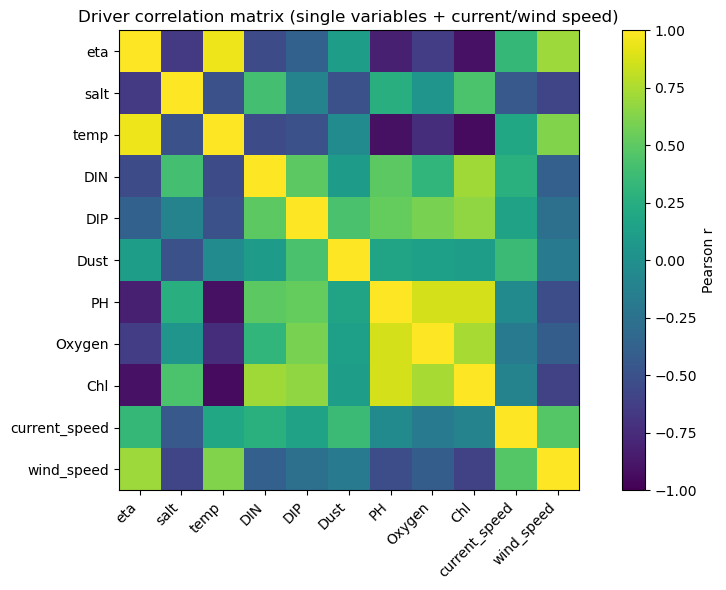

✅ Saved: 2mix_corr_with_curr_wind_single_with_curr_wind.png / 2mix_corr_with_curr_wind_single_with_curr_wind.csv


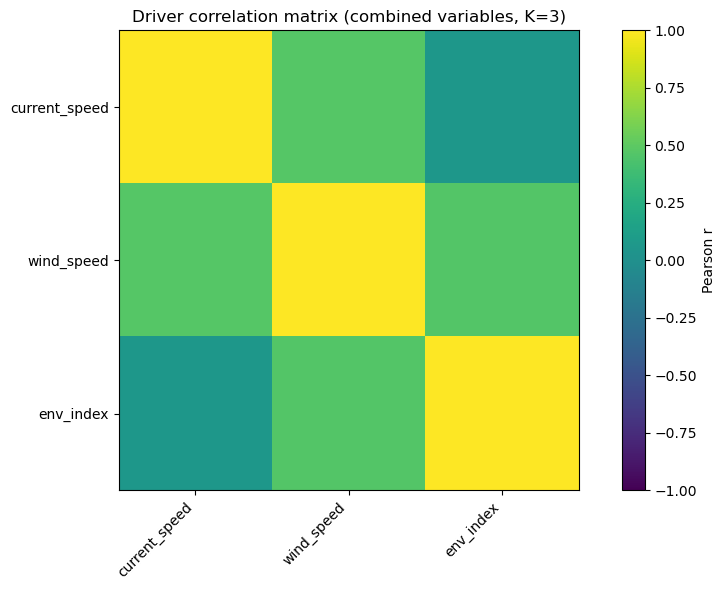

✅ Saved: 2mix_corr_with_curr_wind_combined_K3.png / 2mix_corr_with_curr_wind_combined_K3.csv


In [ ]:
=
# The image will be displayed below the code, and each should be saved separately. PNG/CSV

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Configuration ----------
CSV_NAME   = "2mix.csv"
K          = 3   # Number of integrated variables：2 / 3 / 4
OUT_PREFIX = "2mix_corr_with_curr_wind"
# ------------------------

# Tool: Loose matching for column names (ignores case/spaces/hyphens)
def _norm_map(cols): return {c.lower().replace(" ", "_").replace("-", "_"): c for c in cols}
def _find(df, names):
    m = _norm_map(df.columns)
    for n in names:
        k = n.lower().replace(" ", "_").replace("-", "_")
        if k in m: return m[k]
    return None
def _z(s):
    mu, sd = s.mean(skipna=True), s.std(ddof=0, skipna=True)
    if not np.isfinite(sd) or sd == 0: sd = 1.0
    return (s - mu) / sd

def plot_corr(df_vars: pd.DataFrame, title: str, outpng: Path):
    corr = df_vars.corr(method="pearson")
    # 显示
    plt.figure(figsize=(9, 6))
    plt.imshow(corr.values, aspect="equal", interpolation="nearest", vmin=-1, vmax=1)
    labels = list(corr.columns)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    cbar = plt.colorbar(); cbar.set_label("Pearson r")
    plt.title(title); plt.tight_layout(); plt.show()
    # 保存
    plt.figure(figsize=(9, 6))
    plt.imshow(corr.values, aspect="equal", interpolation="nearest", vmin=-1, vmax=1)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(label="Pearson r")
    plt.title(title); plt.tight_layout()
    plt.savefig(outpng, dpi=300); plt.close()
    corr.to_csv(outpng.with_suffix(".csv"), index=True)
    print(f"✅ Saved: {outpng.name} / {outpng.with_suffix('.csv').name}")

# 1) read
path = Path(CSV_NAME)
if not path.exists(): raise FileNotFoundError(f"cant find file：{path.resolve()}")
df = pd.read_csv(path)

# 2) —— single variable ——（delete date、TOTAL_COTS、MEAN_COTS_PER_TOW、TOWS；join current_speed & wind_speed）
base_names = ["eta","salt","temp","u","v","wspeed_u","wspeed_v",
              "DIN","DIP","Dust","PH","Oxygen","Chl"]  # The main variable in  diagram
picked = []
for n in base_names:
    col = _find(df, [n])
    if col is not None: picked.append(col)
    else: print(f"⚠️ skip（cant find lines）：{n}")

# get current_speed and wind_speed
cur_col = _find(df, ["current_speed","current speed"])
wind_col= _find(df, ["wind_speed","wind speed"])
if cur_col is None:
    u_col = _find(df, ["u"]); v_col = _find(df, ["v"])
    if u_col is None or v_col is None:
        raise KeyError("Lack current_speed and u/v，cant join。")
    cur_series = np.hypot(pd.to_numeric(df[u_col], errors="coerce"),
                          pd.to_numeric(df[v_col], errors="coerce"))
    cur_col = "current_speed(calc)"
else:
    cur_series = pd.to_numeric(df[cur_col], errors="coerce")

if wind_col is None:
    wu_col = _find(df, ["wspeed_u","wind_u","wu"])
    wv_col = _find(df, ["wspeed_v","wind_v","wv"])
    if wu_col is None or wv_col is None:
        raise KeyError("lack wind_speed and wspeed_u/wspeed_v，cant join。")
    wind_series = np.hypot(pd.to_numeric(df[wu_col], errors="coerce"),
                           pd.to_numeric(df[wv_col], errors="coerce"))
    wind_col = "wind_speed(calc)"
else:
    wind_series = pd.to_numeric(df[wind_col], errors="coerce")

single_df = df[picked].apply(pd.to_numeric, errors="coerce").copy()
single_df[cur_col]  = cur_series.values
single_df[wind_col] = wind_series.values
single_df = single_df.dropna(axis=1, how="all")
plot_corr(single_df, "Driver correlation matrix (single variables + current/wind speed)",
          Path(f"{OUT_PREFIX}_single_with_curr_wind.png"))

# 3) —— combine variable picture（K=2/3/4）——
eta  = pd.to_numeric(df[_find(df, ["eta"])], errors="coerce")
salt = pd.to_numeric(df[_find(df, ["salt"])], errors="coerce")
temp = pd.to_numeric(df[_find(df, ["temp","temperature"])], errors="coerce")

# Directly reuse the above cur_series / wind_series
env_index     = pd.concat([_z(eta), _z(salt), _z(temp)], axis=1).mean(axis=1)
temp_salt_idx = pd.concat([_z(temp), _z(salt)], axis=1).mean(axis=1)
eta_z         = _z(eta)

if K == 2:
    comb = pd.DataFrame({"current_speed": cur_series, "wind_speed": wind_series})
elif K == 3:
    comb = pd.DataFrame({"current_speed": cur_series, "wind_speed": wind_series, "env_index": env_index})
elif K == 4:
    comb = pd.DataFrame({"current_speed": cur_series, "wind_speed": wind_series,
                         "temp_salt_index": temp_salt_idx, "eta_z": eta_z})
else:
    raise ValueError("K only 2 / 3 / 4")

comb = comb.dropna(axis=1, how="all")
plot_corr(comb, f"Driver correlation matrix (combined variables, K={K})",
          Path(f"{OUT_PREFIX}_combined_K{K}.png"))